In [3]:
import pandas as pd
import numpy as np
import vartests
from scipy.stats import norm
import matplotlib.pyplot as plt
import arviz as az
from dieboldmariano import dm_test

0.2.2


In [4]:
def read_facts(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/data_raw/prices_raw/zone_{zone}/zone_{zone}_hour_{hour}.csv')
    df = df[1352:].reset_index(drop=True)
    return df

def read_preds(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}/zone_{zone}_hour_{hour}.csv')
    return df

def read_raw(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}/raw_model/zone_{zone}_hour_{hour}.csv')
    return df

def read_aug(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}/augmented_model/zone_{zone}_hour_{hour}.csv')
    return df

def read_arx(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/arx_{zone}/arx_{zone}_hour_{hour}.csv')
    return df

def read_arx_2(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/arx_2_{zone}/arx_{zone}_hour_{hour}_2.csv')
    return df

def read_arx_new(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/arx_{zone}_new/arx_{zone}_hour_{hour}.csv')
    return df

def read_2(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}_2/zone_{zone}_hour_{hour}_2.csv')
    return df

def read_new_raw(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}_new_raw/zone_{zone}_hour_{hour}.csv')
    return df

def read_new_aug(zone, hour):
    df = pd.read_csv(f'/home/tim/dv/bsv_inference/results/zone_{zone}_new_aug/zone_{zone}_hour_{hour}.csv')
    return df

In [128]:
def plot_univariate(df, col):
    # Create histogram
    plt.figure(figsize=(8, 6))
    plt.hist(df[col], bins=30, density=True, alpha=0.6, color='b')

    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col}')
    plt.show()

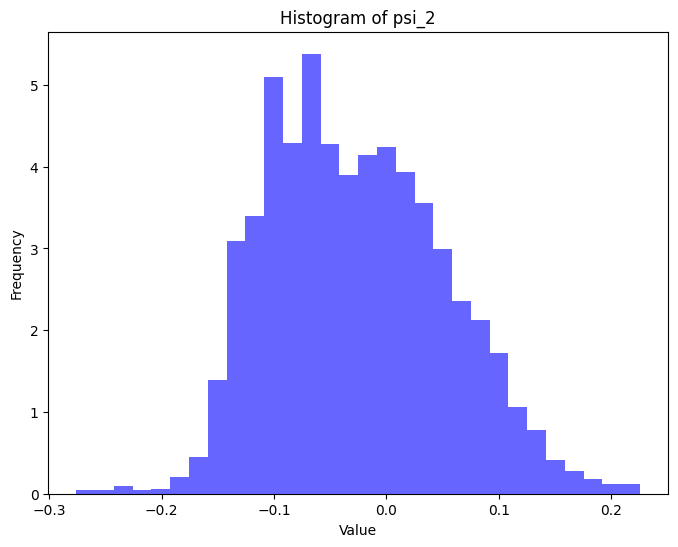

In [21]:
plot_univariate(read_preds(0,0), 'psi_2')

In [15]:
def calculate_quantiles(zone, hour):
    df = read_new_aug(zone, hour)
    quantiles = []
    for i in range(800, 1000):
        q1 = np.percentile(df[f'y_rep.{i}'], 25)
        q3 = np.percentile(df[f'y_rep.{i}'], 75)
        quantiles.append((q1, q3))
    return quantiles

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


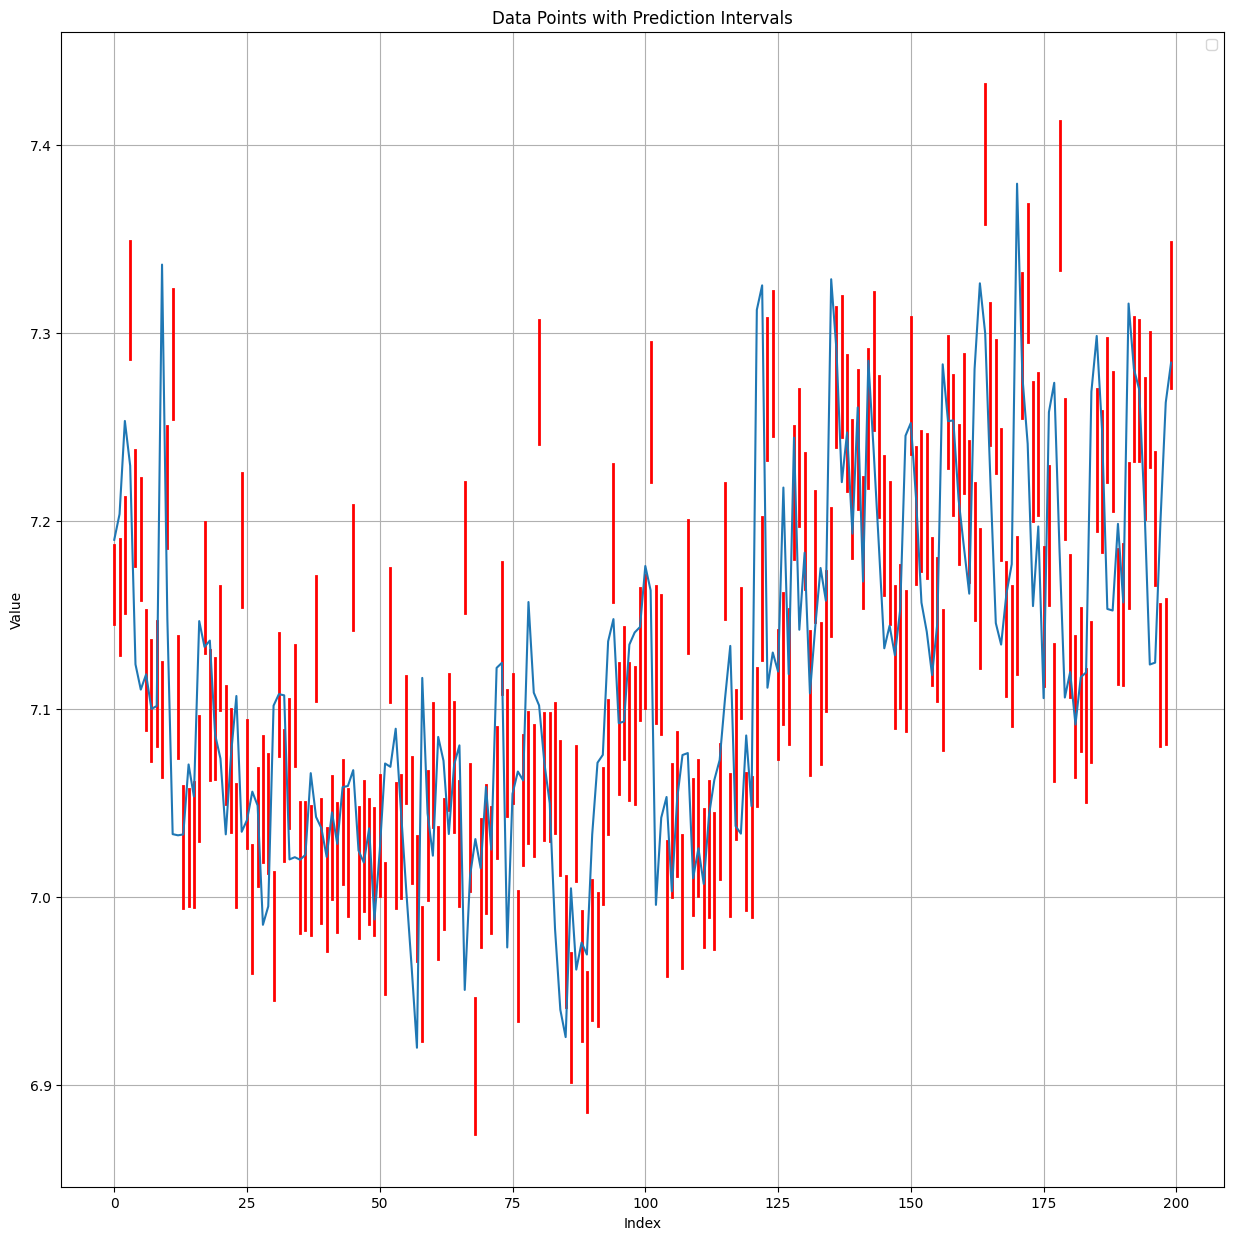

In [16]:
quantiles = calculate_quantiles(1, 0)
data = read_facts(1,0)
plt.figure(figsize=(15,15))

for i, (lower, upper) in enumerate(quantiles):
    plt.plot([i, i], [lower, upper], color='red', linewidth=2)
plt.plot(np.log(data['prices']))
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(data)), data, color='blue', label='Data Points')

# # Plot prediction intervals
# for i, (lower, upper) in enumerate(quantiles):
#     plt.plot([i, i], [lower, upper], color='red', linewidth=2)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Points with Prediction Intervals')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
def calculate_hpd(zone, hour, hdi_prob):
    df = read_new_aug(zone, hour)
    hpd_arr = []
    for i in range(800, 1000):
        hpd = az.hdi(df[f'y_rep.{i}'].to_numpy(), hdi_prob=hdi_prob)
        hpd_arr.append(hpd)
    return hpd_arr

In [20]:
hdi_90 = calculate_hpd(1,0,0.9)

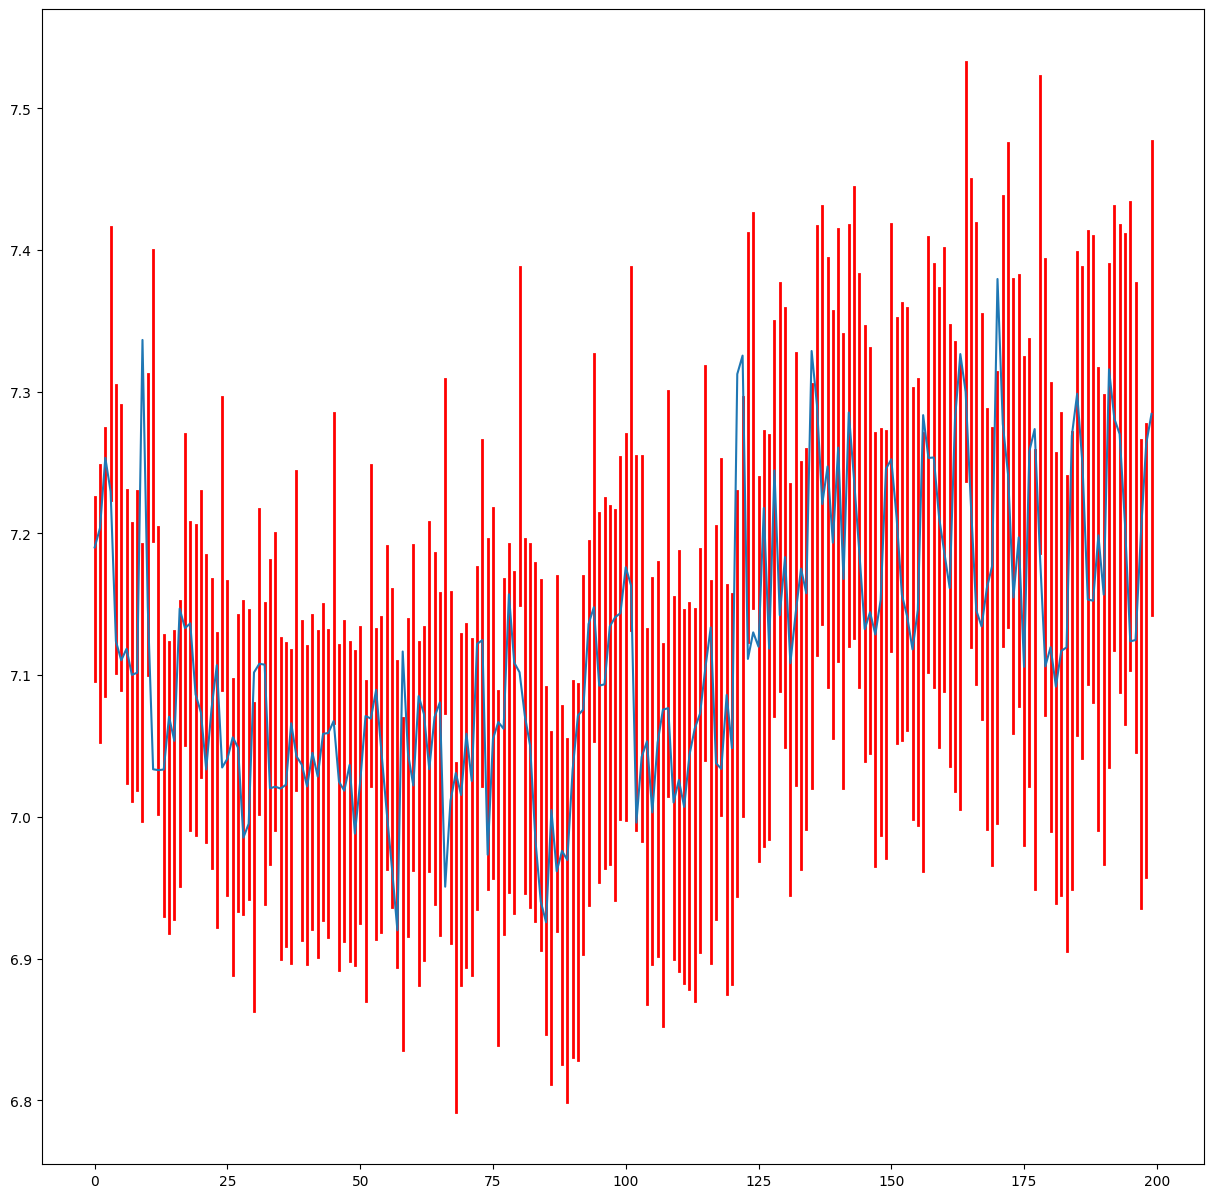

In [21]:
data = read_facts(1,0)
plt.figure(figsize=(15,15))

# for i, (lower, upper) in enumerate(hdi_50):
#     plt.plot([i, i], [lower, upper], color='red', linewidth=2)
for i, (lower, upper) in enumerate(hdi_90):
    plt.plot([i, i], [lower, upper], color='red', linewidth=2)
plt.plot(np.log(data['prices']))

In [467]:
from scipy import stats


def lr_bt(actual, forecast, alpha):
        """Likelihood ratio framework of Christoffersen (1998)"""
        hits = (actual < forecast[0]) * 1 + (actual > forecast[1]) * 1  # Hit series
        tr = hits[1:] - hits[:-1]  # Sequence to find transitions

        # Transitions: nij denotes state i is followed by state j nij times
        n01, n10 = (tr == 1).sum(), (tr == -1).sum()
        n11, n00 = (hits[1:][tr == 0] == 1).sum(), (hits[1:][tr == 0] == 0).sum()

        # Times in the states
        n0, n1 = n01 + n00, n10 + n11
        n = n0 + n1

        # Probabilities of the transitions from one state to another
        p01, p11 = n01 / (n00 + n01), n11 / (n11 + n10)
        p = n1 / n

        if n1 > 0:
            # Unconditional Coverage
            uc_h0 = n0 * np.log(1 - alpha) + n1 * np.log(alpha)
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p)
            uc = -2 * (uc_h0 - uc_h1)

            # Independence
            ind_h0 = (n00 + n01) * np.log(1 - p) + (n01 + n11) * np.log(p)
            ind_h1 = n00 * np.log(1 - p01) + n01 * np.log(p01) + n10 * np.log(1 - p11)
            if p11 > 0:
                ind_h1 += n11 * np.log(p11)
            ind = -2 * (ind_h0 - ind_h1)

            # Conditional coverage
            cc = uc + ind

            # Stack results
            df = pd.concat([pd.Series([uc, ind, cc]),
                            pd.Series([1 - stats.chi2.cdf(uc, 1),
                                       1 - stats.chi2.cdf(ind, 1),
                                       1 - stats.chi2.cdf(cc, 2)])], axis=1)
        else:
            df = pd.DataFrame(np.zeros((3, 2))).replace(0, np.nan)

        # Assign names
        df.columns = ["Statistic", "p-value"]
        df.index = ["Unconditional", "Independence", "Conditional"]
        return df

In [468]:
def christoffensen_quantiles(zone, hour, alpha):
    facts = read_facts(zone, hour)
    qarr = calculate_quantiles(zone,hour)
    qarr = np.array(qarr).T
    return lr_bt(np.log(facts['prices'].to_numpy()), qarr, alpha)

In [392]:
quant_5 = []
quant_1 = []
for i in range(24):
    quant_1.append(christoffensen_quantiles(2,i,0.01))
    quant_5.append(christoffensen_quantiles(2,i,0.05))

In [479]:
def christoffensen(zone, hour, pi ,alpha):
    facts = read_facts(zone, hour)
    qarr = calculate_hpd(zone,hour, pi)
    qarr = np.array(qarr).T
    return lr_bt(np.log(facts['prices'].to_numpy()), qarr, alpha)

In [480]:
chris_05_5 = []
chris_05_1 = []
chris_09_5 = []
chris_09_1 = []
for i in range(24):
    chris_05_5.append(christoffensen(1,i,0.5,0.05))
    chris_05_1.append(christoffensen(1,i,0.5,0.01))
    chris_09_5.append(christoffensen(1,i,0.9,0.05))
    chris_09_1.append(christoffensen(1,i,0.9,0.01))

In [481]:
unc_09_5 = []
unc_09_1 = []
for i in range(len(chris_09_5)):
    unc_09_5.append(chris_09_5[i].iloc[2,0])
    unc_09_1.append(chris_09_1[i].iloc[2,0])

# unc_09_1 = np.nan_to_num(np.array(unc_09_1), nan=0)

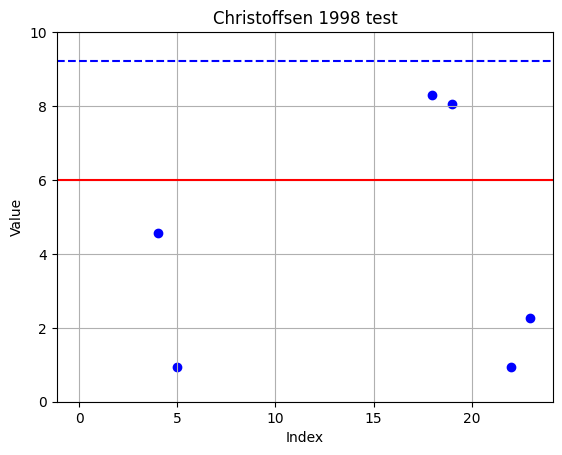

In [482]:
# Generate x-axis values (index of the array)
indices = range(len(chris_09_5))

# Adding horizontal lines
plt.axhline(y=5.991, color='red', linestyle='-', label='y=3.841')
plt.axhline(y=9.21, color='blue', linestyle='--', label='y=6.635')

# Plotting
plt.scatter(indices, unc_09_5, color='blue')
plt.scatter(indices, unc_09_1, color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0, 10)
plt.title('Christoffsen 1998 test')
plt.grid(True)
plt.show()

In [393]:
unc_05_1 = []
unc_09_1 = []
for i in range(len(chris_05_1)):
    unc_05_1.append(quant_1[i].iloc[0,0])
    unc_09_1.append(quant_5[i].iloc[0,0])

unc_09_1 = np.nan_to_num(np.array(unc_09_1), nan=0)

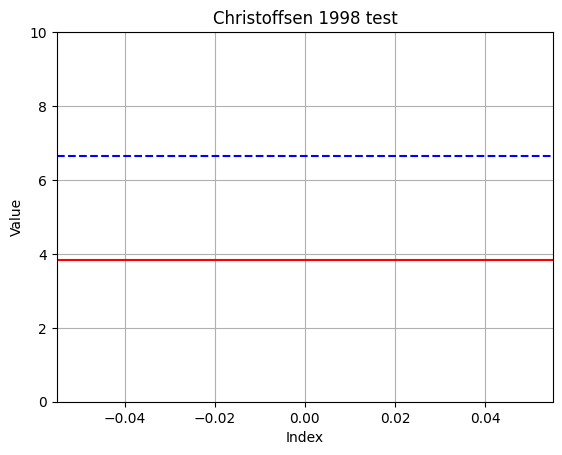

In [394]:
# Generate x-axis values (index of the array)
indices = range(len(chris_05_1))

# Adding horizontal lines
plt.axhline(y=3.841, color='red', linestyle='-', label='y=3.841')
plt.axhline(y=6.635, color='blue', linestyle='--', label='y=6.635')

# Plotting
plt.scatter(indices, unc_05_1, color='blue')
plt.scatter(indices, unc_09_1, color='red')
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0, 10)
plt.title('Christoffsen 1998 test')
plt.grid(True)
plt.show()

In [ ]:
def kupiec(zone, hour):
    df = read_new(zone, hour)

In [454]:
def berkowitz(zone, hour):
    df = read_arx(zone, hour)
    # Define initial date
    initial_date = '2023-09-13'
    # Define number of days
    num_days = 200
    log_prices_arr = []
    for i in range(800, 1000):
        log_prices_arr.append(np.median(df[f'y_rep.{i}']))

    log_prices_arr = np.array(log_prices_arr)
    # Create datetime range starting from initial date
    date_range = pd.date_range(start=initial_date, periods=num_days)
    # Create a DataFrame with datetime and corresponding values
    res_df1 = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr)})
    test = vartests.berkowtiz_tail_test(pd.DataFrame(res_df1['LogPrices']))
    return test['solution'], test['LR'], test['decision']

In [455]:
berkowitz(1,3)

Normalizing returns...


0it [00:00, ?it/s]

Optimizing...

Elapsed time: 0.10728645324707031 s


(Result(parameters=[-0.7222317116133397, 0.15762804866911262], obj_value=0, converged=True),
 0,
 'Fail to Reject H0')

In [187]:
berkowitz(1,0)

Normalizing returns...


100%|██████████| 110/110 [00:00<00:00, 149.33it/s]


Optimizing...

Elapsed time: 0.20879125595092773 s


(Result(parameters=[1.3220079510497837, 1.7440714260824604], obj_value=11.084501900381756, converged=True),
 1.8775000902801793,
 'Fail to Reject H0')

In [198]:
def kupiec(zone, hour, pi):
    facts = read_facts(zone,hour)
    hdi_90 = calculate_hpd(zone,hour,pi)
    hdi_90 = np.array(hdi_90).T
    hits = (np.log(facts['prices'].to_numpy()) < hdi_90[0]) * 1 + (np.log(facts['prices'].to_numpy()) > hdi_90[1]) * 1  # Hit series
    return vartests.kupiec_test(hits)

{'log-likelihood': 0.4378496777695684,
 'chi square critical value': 3.841458820694124,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

In [8]:
def check_arx(zone, hour):
    # arx = read_new_aug(zone, hour)
    arx = read_arx(zone, hour)
    preds = read_2(zone,hour)
    facts = read_facts(zone, hour)
    # Define initial date
    initial_date = '2023-09-13'
    # Define number of days
    num_days = 200
    log_prices_arr = []
    arx_log = []
    for i in range(800, 1000):
        log_prices_arr.append(np.median(preds[f'y_rep.{i}']))
        arx_log.append(np.median(arx[f'y_rep.{i}']))

    log_prices_arr = np.array(log_prices_arr)
    arx_arr = np.array(arx_log)
    # Create datetime range starting from initial date
    date_range = pd.date_range(start=initial_date, periods=num_days)
    # Create a DataFrame with datetime and corresponding values
    res_df1 = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(log_prices_arr)})
    res_arx = pd.DataFrame({'Datetime': np.array(date_range), 'LogPrices': np.array(arx_arr)})

    return dm_test(np.log(facts['prices']), res_df1['LogPrices'], res_arx['LogPrices'])

In [9]:
check_arx(1,1)

(-0.46616509426732017, 0.6416071917944779)

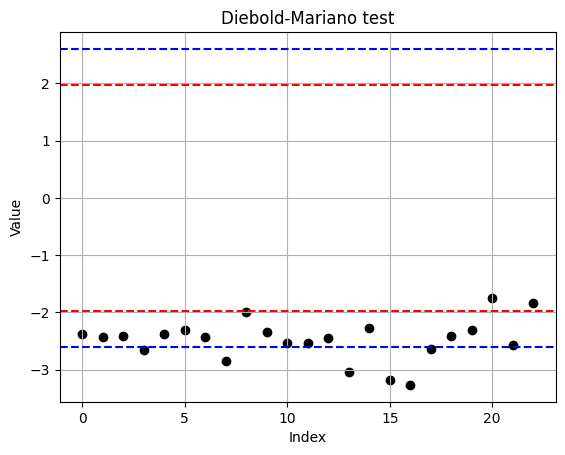

In [26]:
dm_res = []
for i in range(23):
    dm_res.append(check_arx(2, i))

indices = range(len(dm_res))
plt.axhline(y=1.97196, color='red', linestyle='--', label='.05 alpha')
plt.axhline(y=-1.97196, color='red', linestyle='--', label='.05 alpha')

plt.axhline(y=2.60076, color='blue', linestyle='--', label='.01 alpha')
plt.axhline(y=-2.60076, color='blue', linestyle='--', label='.01 alpha')

plt.scatter(x=indices,y=np.array(dm_res).T[0], color='black')
# plt.scatter(x=indices,y=np.array(dm_res).T[1])

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Diebold-Mariano test')
plt.grid(True)
plt.show()

In [79]:
np.array(dm_res).T

array([[-2.91518146e+00,  2.79613608e+00, -3.76167092e+00,
        -3.12931471e+00, -3.96885137e+00,  6.70242797e+00],
       [ 3.96228218e-03,  5.67875125e-03,  2.21934195e-04,
         2.01546291e-03,  1.00801762e-04,  2.06336806e-10]])